# Alpha Analysis - electron lifetime, channel calibration, charge yield

In [2]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.TMSUtilities.GetCuts import Cut
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time,copy

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15

analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/Run_Parameters_Xe_Run29.csv')
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']
path_to_reduced = '/p/lustre1/jacopod/29th/analysis_500ns/20200213_AfterRnInjection'

In [3]:
start_time = time.time()
df = pd.read_hdf(path_to_reduced + '/reduced_added.h5')
print('datafrfgame with {} events loaded in {:.1f}s'.format(df.shape[0],time.time() - start_time))
DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
for k in df.keys():
    print(k)

dataframe with 1243966 events loaded in 51.3s
ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
TileStrip X1-12 Baseline
TileStrip X1-12 Baseline RMS
TileStrip X1-12 Charge Energy
TileStrip X1-12 Drift Time
TileStrip X1-12 T10
TileStrip X1-12 T25
TileStrip X1-12 T50
TileStrip X1-12 T90
TileStrip X13 Baseline
TileStrip X13 Baseline RMS
TileStrip X13 Charge Energy
TileStrip X13 Drift Time
TileStrip X13 T10
TileStrip X13 T25
TileStrip X13 T50
TileStrip X13 T90
TileStrip X14 Baseline
TileStrip X14 Baseline RMS
TileStrip X14 Charge Energy
TileStrip X14 Drift Time
TileStrip X14 T10
TileStrip X14 T25
TileStrip X14 T50
TileStrip X14 T90
TileStr

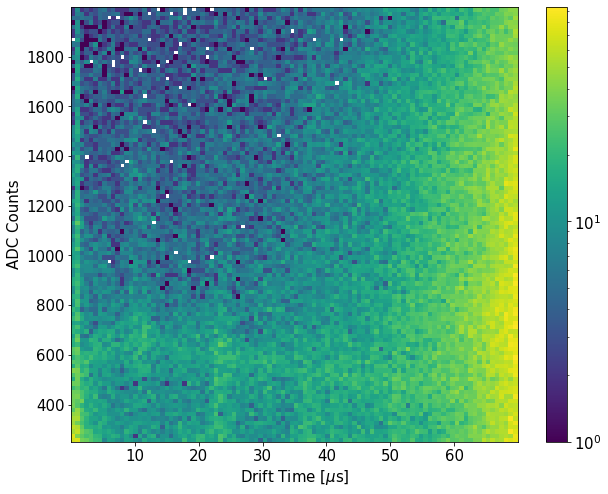

In [4]:
min_time = 0
max_time = 70
cut_array = ['DriftTime>{}'.format(min_time), 'DriftTime<{}'.format(max_time),\
            'TotalTileEnergy>250', 'TotalTileEnergy<2000']
derived_dict = {'DriftTime':DriftTime}
cut = Cut(cut_array,df,derived_dict)
mask = cut.mask
plt.hist2d(DriftTime[mask], df['TotalTileEnergy'][mask], bins=100, norm=LogNorm())
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('ADC Counts')
plt.colorbar()

## Electron lifetime

In [5]:
def fit_function(x, A, beta, B, mu, sigma):
    return (A * np.exp(-x/beta) +\
            B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))
def exp_function(x, A, beta):
    return(A * np.exp(-x/beta))

slicing into ~10$\mu$s windows and fitting the alpha peak

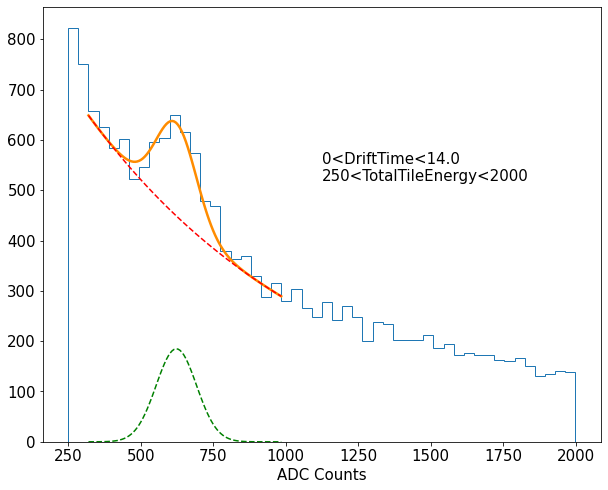

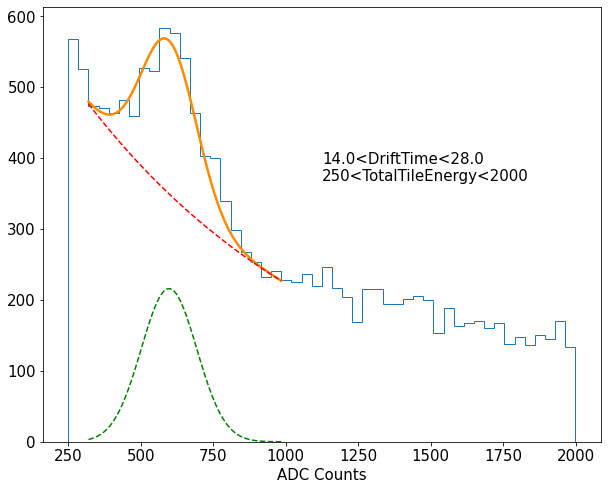

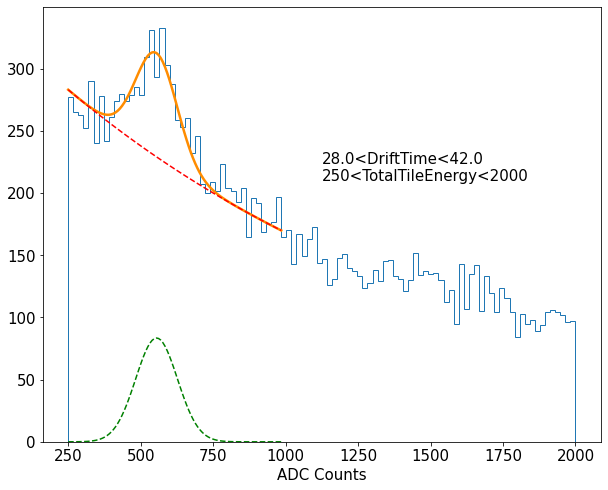

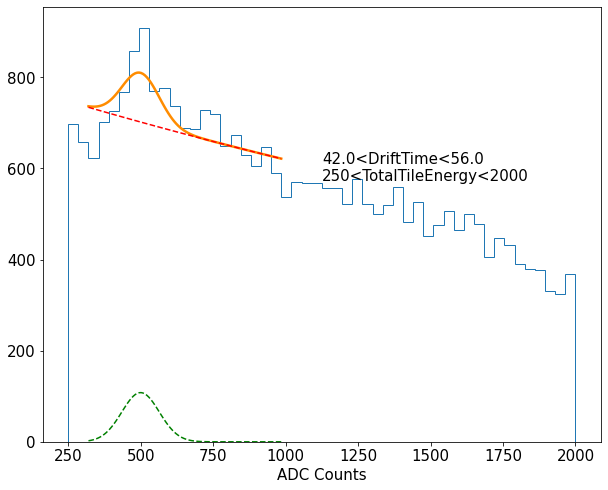

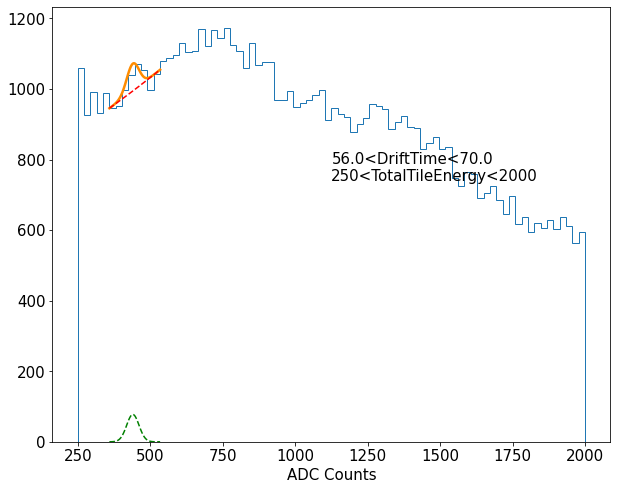

In [6]:
fit_data = {'time':[],'peak':[],'peak_error':[]}
p0 = ([None],[1000,800,150,500,40],[500,800,120,500,80],[300,800,60,500,40],[600,4000,60,400,40],[900,-8000,50,500,50])
slices = 6
for i,rg in enumerate(np.linspace(min_time,max_time,slices)):

    bins = 50
    fit_range = [300,1000]
    if i == 0:
        rg_0 = min_time
        continue
    bounds = (np.asarray(p0[i])*0.2,np.asarray(p0[i])*1.8)
    if i == slices - 1:
        fit_range = [250,600]
    if i  == 3:
        bins = 100
        fit_range = [250,1000]
    if i == slices-1:
        mask1 = np.logical_and(mask1,df['NumTileChannelsHit']==1)
        fit_range = [350,550]
        bins = 80
        bounds[0][1] = p0[i][1]*1.8
        bounds[1][1] = p0[i][1]*0.2

    cut_array1 = cut_array[2:] + ['DriftTime>{}'.format(rg_0), 'DriftTime<{}'.format(rg)]
    cut1 = Cut(cut_array1,df,derived_dict)
    mask1 = cut1.mask
    data, bin_edges,_ = plt.hist(df['TotalTileEnergy'][mask1],bins=bins,histtype='step')
    bin_width = bin_edges[1]-bin_edges[0]
    fit_idx = np.where((bin_edges>fit_range[0]) & (bin_edges<fit_range[1]))[0]
    popt, pcov = curve_fit(fit_function, xdata=bin_edges[fit_idx], ydata=data[fit_idx],p0=p0[i],bounds=bounds)
    fit_x_bin = np.linspace(bin_edges[fit_idx][0],bin_edges[fit_idx][-1],100)
    plt.plot(fit_x_bin, fit_function(fit_x_bin, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
    popt_buffer = copy.deepcopy(popt)
    for ix,j in zip((0,2),('green','red')):
        popt[ix] = 0
        plt.plot(fit_x_bin, fit_function(fit_x_bin, *popt), color=j, linewidth=1.5,linestyle='dashed')
        popt = copy.deepcopy(popt_buffer)
    plt.text(0.5, 0.6, cut1.GetString('\n'), transform = plt.gca().transAxes)
    plt.xlabel('ADC Counts')
    plt.show()
    fit_data['time'].append((rg + rg_0)/2)
    fit_data['peak'].append(popt[3])
    fit_data['peak_error'].append(np.sqrt(pcov[3,3]) + np.sqrt(popt[3]*bin_width/(popt[2]*np.sqrt(2*np.pi))))
    rg_0 = rg
    
fit_data = pd.DataFrame(fit_data)

Text(0.7, 0.7, 'A = 665.7$\\pm$16.4\n$\\tau$ = 165.9$\\pm$21.4$\\mu$s')

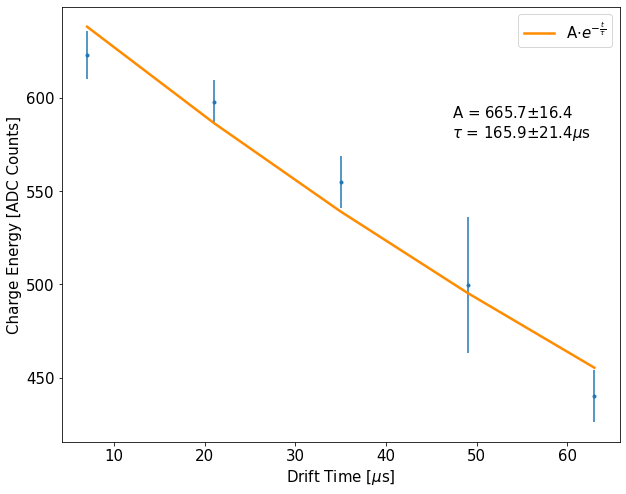

In [7]:
plt.errorbar(fit_data['time'],fit_data['peak'],fit_data['peak_error'],fmt='.')
popt_e, pcov_e = curve_fit(exp_function, xdata=fit_data['time'], ydata=fit_data['peak'],\
                       p0=(600,1000),sigma=fit_data['peak_error'])
text = 'A = {:.1f}$\pm${:.1f}'.format(popt_e[0],np.sqrt(np.diag(pcov_e))[0])+ '\n' +\
r'$\tau$ = {:.1f}$\pm${:.1f}$\mu$s'.format(popt_e[1],np.sqrt(np.diag(pcov_e))[1])
plt.plot(fit_data['time'], exp_function(fit_data['time'], *popt_e), color='darkorange', linewidth=2.5,\
         label=r'A$\cdot e^{-\frac{t}{\tau}}$')
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('Charge Energy [ADC Counts]')
plt.legend()
plt.text(0.7, 0.7, text, transform = plt.gca().transAxes)

## Diffusion

here I apply the purity correction and cut on the SS events, it is possible to see (right plot) how the alpha peak is sharper with purity corrected energy, I'll use this quantity to look at the diffusion

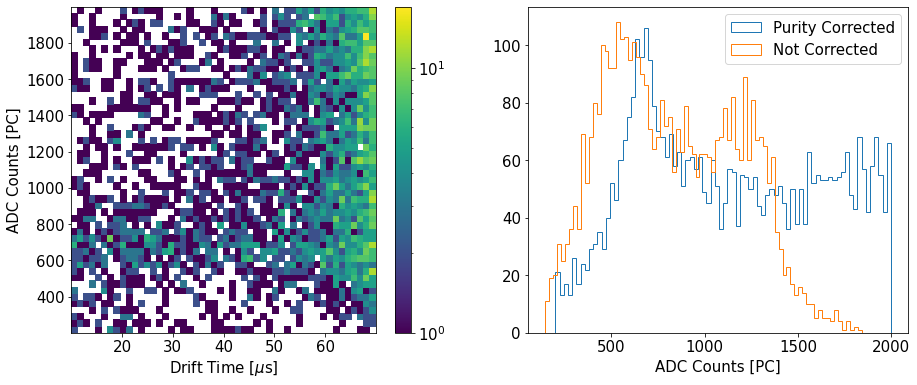

In [8]:
df['Purity-Corrected Charge Energy'] = df['TotalTileEnergy']*np.exp(DriftTime/popt_e[1])
cut_array = ['DriftTime>10', 'DriftTime<70',\
            'Purity-Corrected Charge Energy>200', 'Purity-Corrected Charge Energy<2000']
derived_dict = {'DriftTime':DriftTime}
cut = Cut(cut_array,df,derived_dict)
mask = cut.mask
one_cluster = np.logical_and(df['NumberOfClusters']==1,df['IsFull3D'])
mask0 = np.logical_and(mask,one_cluster)
fig,ax = plt.subplots(1,2,figsize=(15,6))
_,_,_,im = ax[0].hist2d(DriftTime[mask0], df['Purity-Corrected Charge Energy'][mask0], bins=50, norm=LogNorm())
ax[0].set_xlabel('Drift Time [$\mu$s]')
ax[0].set_ylabel('ADC Counts [PC]')
ax[1].hist(df['Purity-Corrected Charge Energy'][mask0],bins=bins,histtype='step', label='Purity Corrected')
ax[1].hist(df['TotalTileEnergy'][mask0],bins=bins,histtype='step', label='Not Corrected')
ax[1].legend()
ax[1].set_xlabel('ADC Counts [PC]')
fig.colorbar(im,ax=ax[0])

here I add the events with signal only on one channel

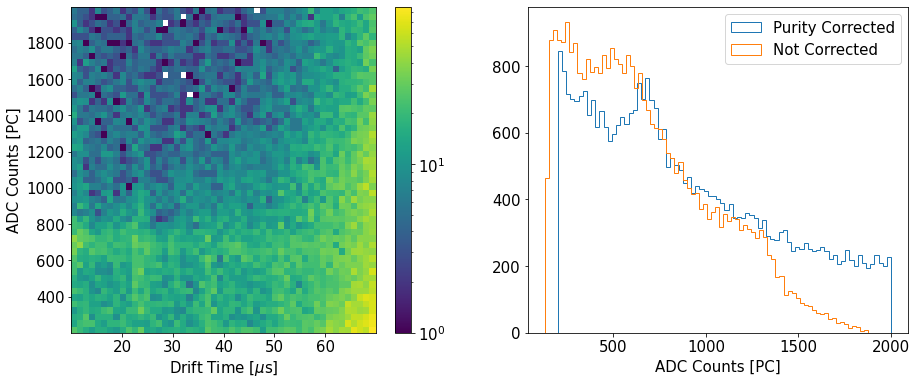

In [9]:
one_cluster_plus_one_ch = np.logical_or(one_cluster,df['NumTileChannelsHit']==1)
mask1 = np.logical_and(mask,one_cluster_plus_one_ch)
fig,ax = plt.subplots(1,2,figsize=(15,6))
_,_,_,im = ax[0].hist2d(DriftTime[mask1], df['Purity-Corrected Charge Energy'][mask1], bins=50, norm=LogNorm())
ax[0].set_xlabel('Drift Time [$\mu$s]')
ax[0].set_ylabel('ADC Counts [PC]')
ax[1].hist(df['Purity-Corrected Charge Energy'][mask1],bins=bins,histtype='step', label='Purity Corrected')
ax[1].hist(df['TotalTileEnergy'][mask1],bins=bins,histtype='step', label='Not Corrected')
ax[1].legend()
ax[1].set_xlabel('ADC Counts [PC]')
fig.colorbar(im,ax=ax[0])

From the plots below it is possible to see no clear sign of diffusion: no matter where the event originated the multiplicity of the event is always one strip, with a small population on two strips (one X and one Y)

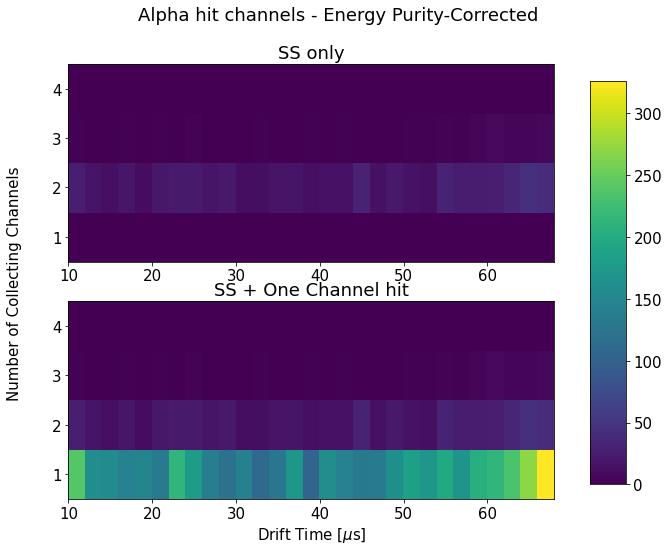

In [10]:
mask_alpha0 = np.logical_and(mask0,\
                            np.logical_and(df['Purity-Corrected Charge Energy']>550,df['Purity-Corrected Charge Energy']<750))
mask_alpha1 = np.logical_and(mask1,\
                            np.logical_and(df['Purity-Corrected Charge Energy']>550,df['Purity-Corrected Charge Energy']<750))
fig,ax = plt.subplots(2,1)
bin_limits_x = np.arange(10,70,2)
bin_limits_y = np.arange(max(df['NumTileChannelsHit'][mask_alpha0])+1) + 0.5
h1,_,_ = np.histogram2d(DriftTime[mask_alpha0],df['NumTileChannelsHit'][mask_alpha0],\
                 bins=[bin_limits_x,bin_limits_y])
bin_limits_y1 = np.arange(max(df['NumTileChannelsHit'][mask_alpha1])+1) + 0.5
h2,_,_ = np.histogram2d(DriftTime[mask_alpha1],df['NumTileChannelsHit'][mask_alpha1],\
                 bins=[bin_limits_x,bin_limits_y])
ax[0].imshow(h1.T,origin='lower',vmin = 0,vmax = max(np.amax(h1),np.amax(h2)), aspect='auto',\
             extent=[bin_limits_x[0],bin_limits_x[-1],bin_limits_y[0],bin_limits_y[-1]])
ax[0].set_title('SS only')
im2 = ax[1].imshow(h2.T,origin='lower',vmax = max(np.amax(h1),np.amax(h2)), aspect='auto',\
             extent=[bin_limits_x[0],bin_limits_x[-1],bin_limits_y[0],bin_limits_y1[-1]])
ax[1].set_xlabel('Drift Time [$\mu$s]')
ax[1].set_title('SS + One Channel hit')
fig.suptitle('Alpha hit channels - Energy Purity-Corrected')
fig.text(0.04, 0.5, 'Number of Collecting Channels', va='center', rotation='vertical')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax)
plt.show()

## Alpha calibration

The SC alphas can be used to calibrate each channel, first I run some sanuty check on each channel. Then I'll uncalibrate the channels (from the wrong calibration) and try to select the alpha peak for the new calibration

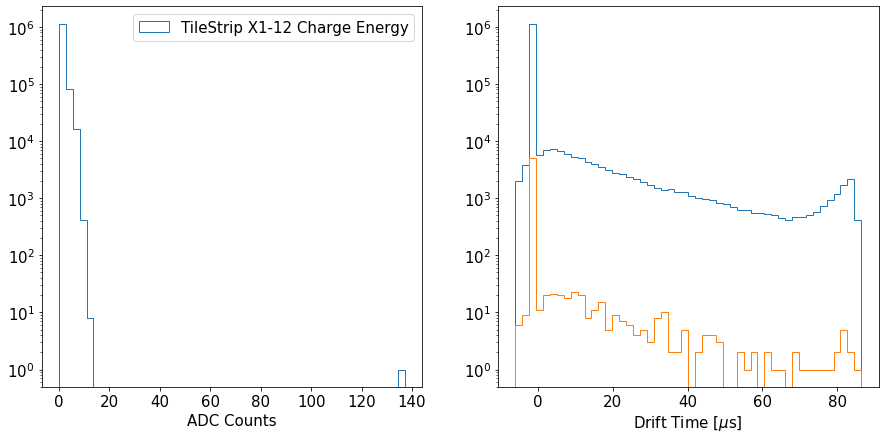

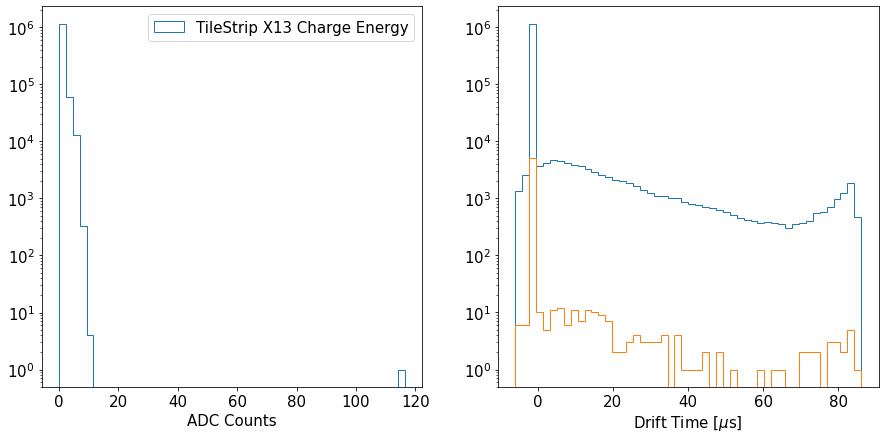

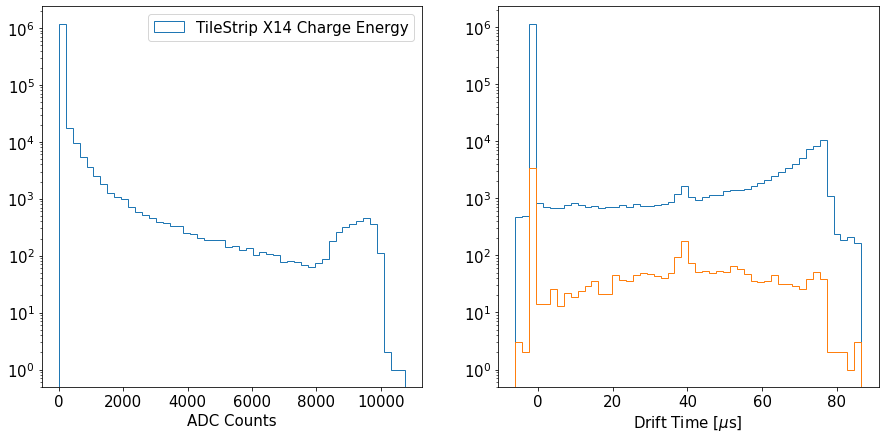

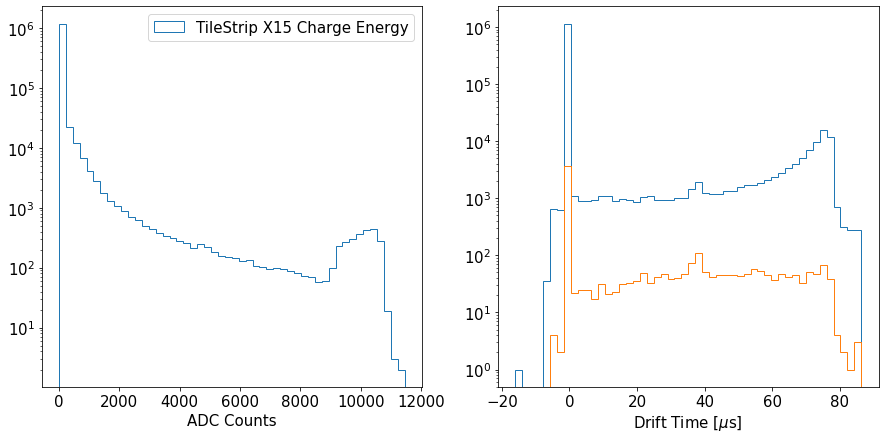

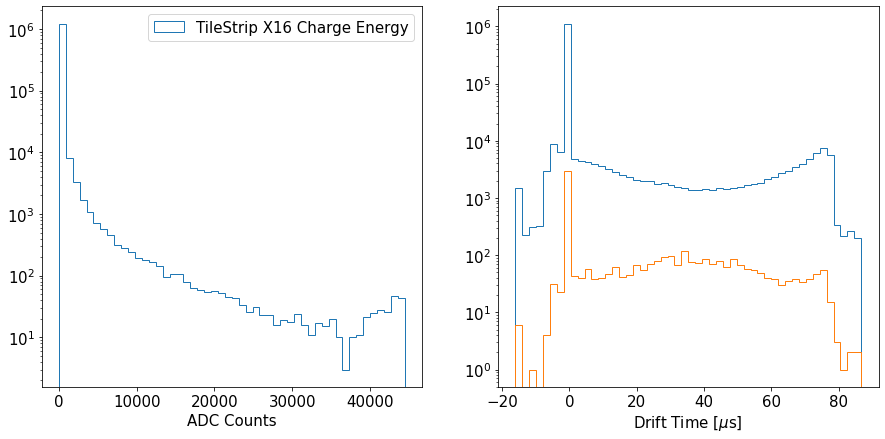

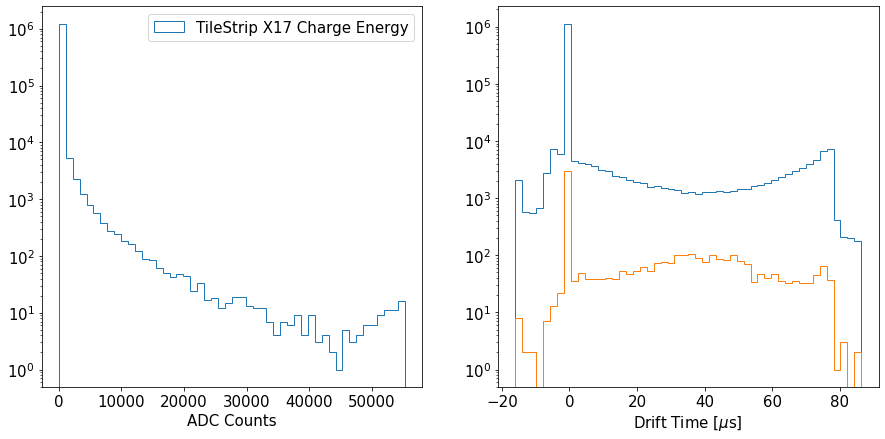

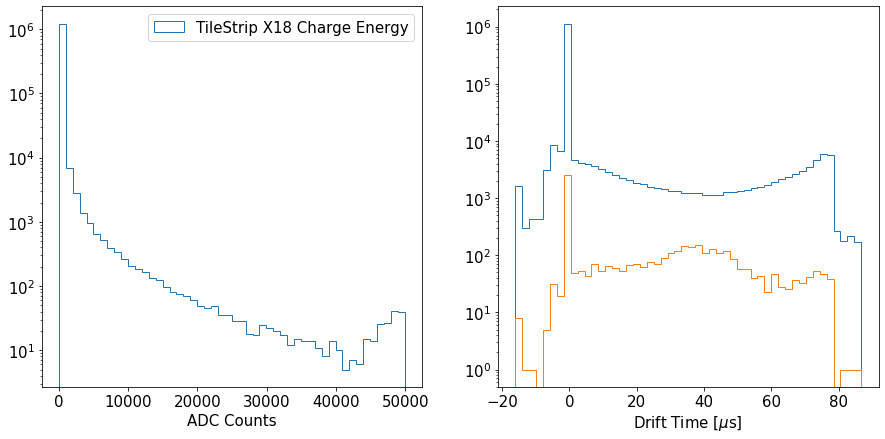

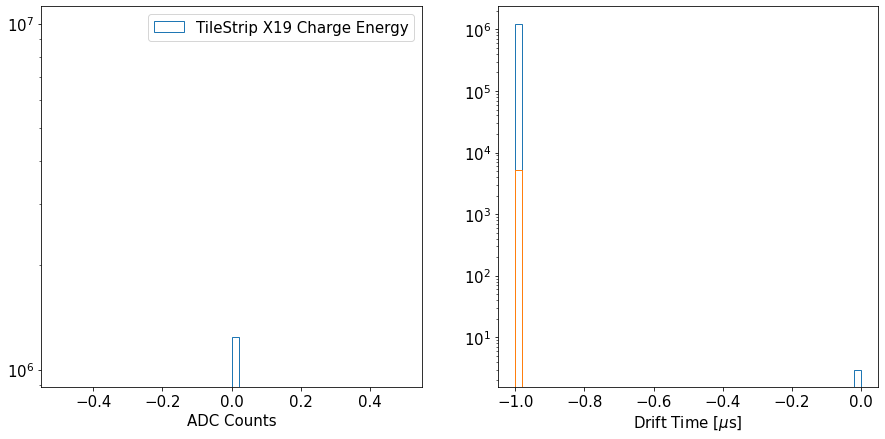

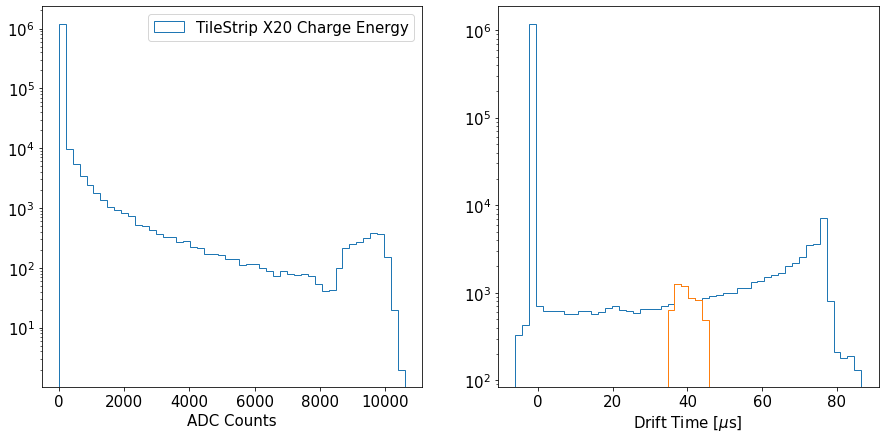

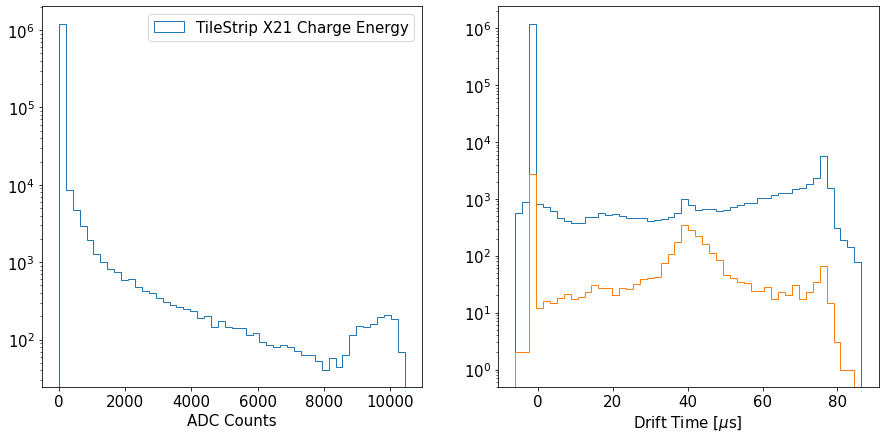

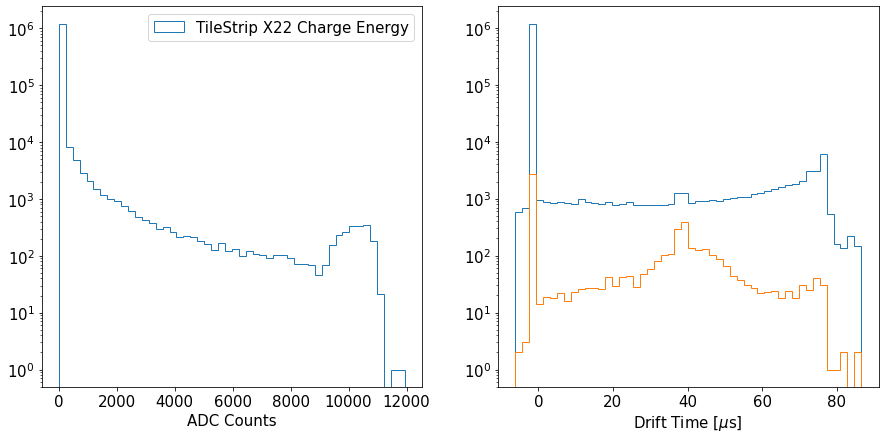

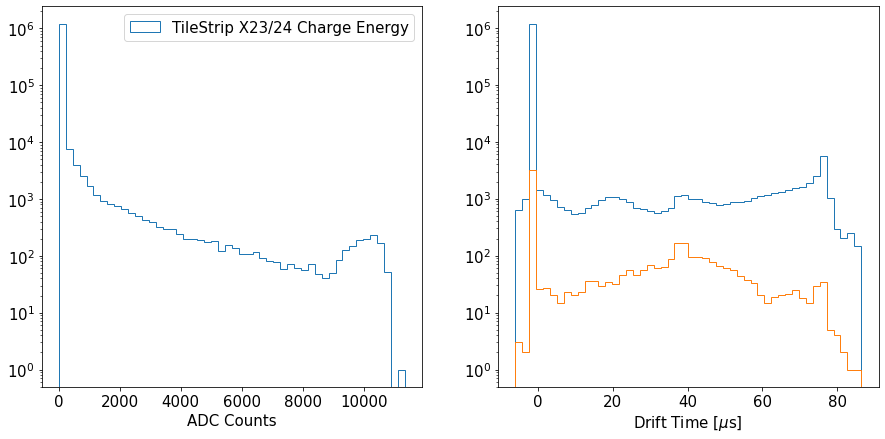

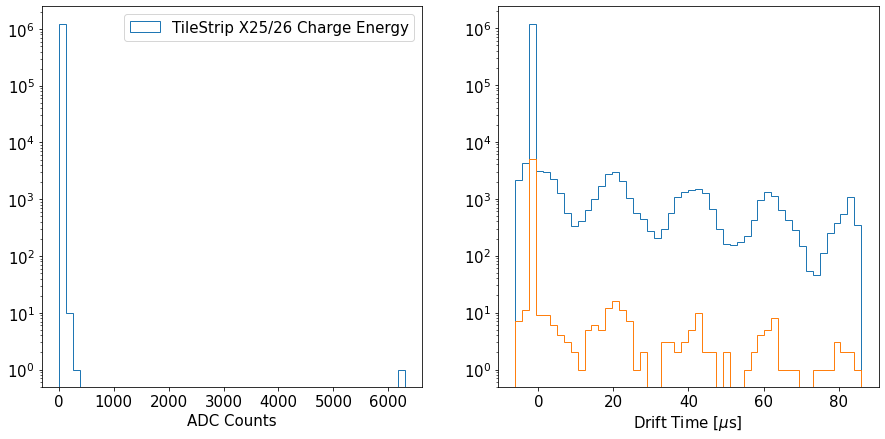

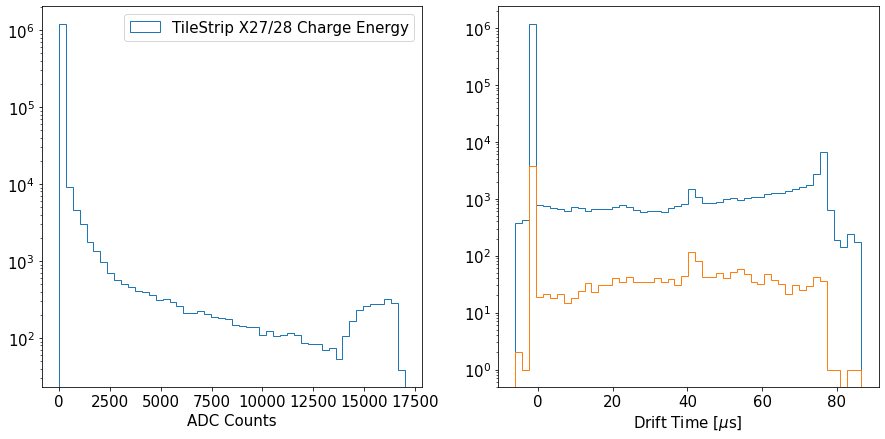

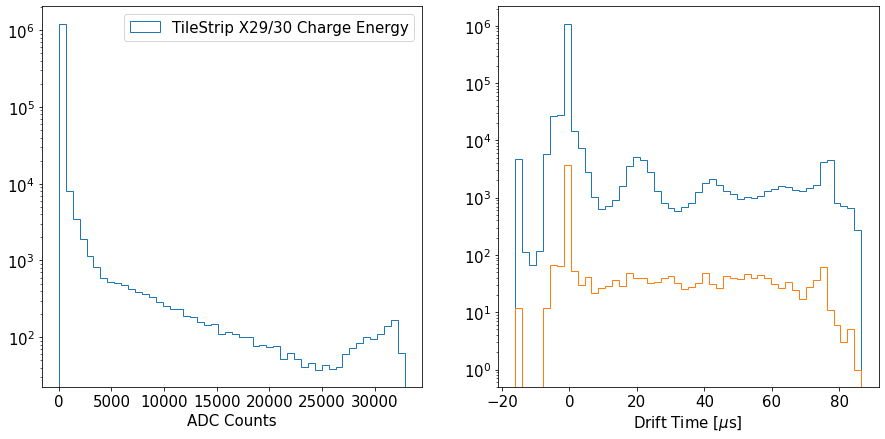

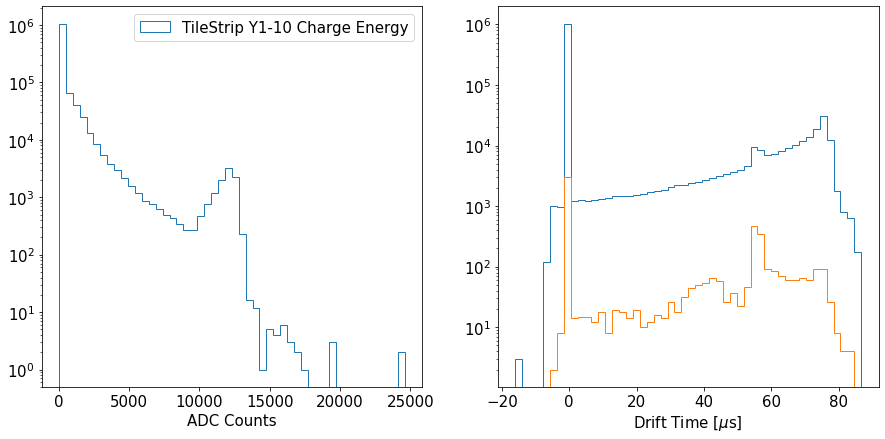

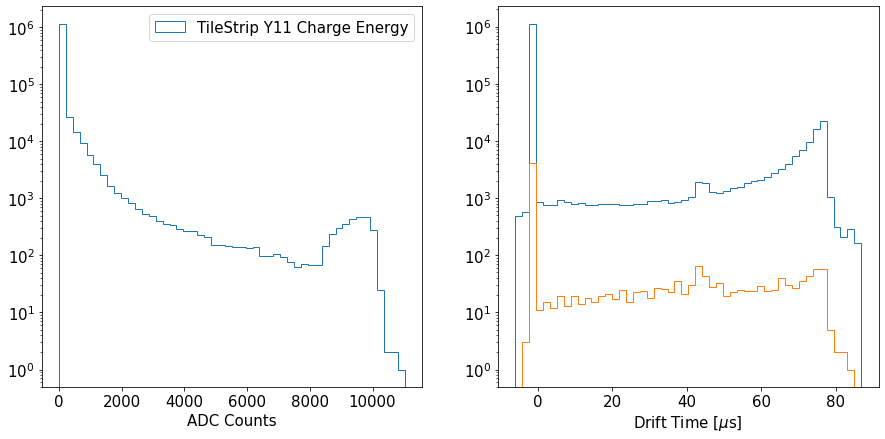

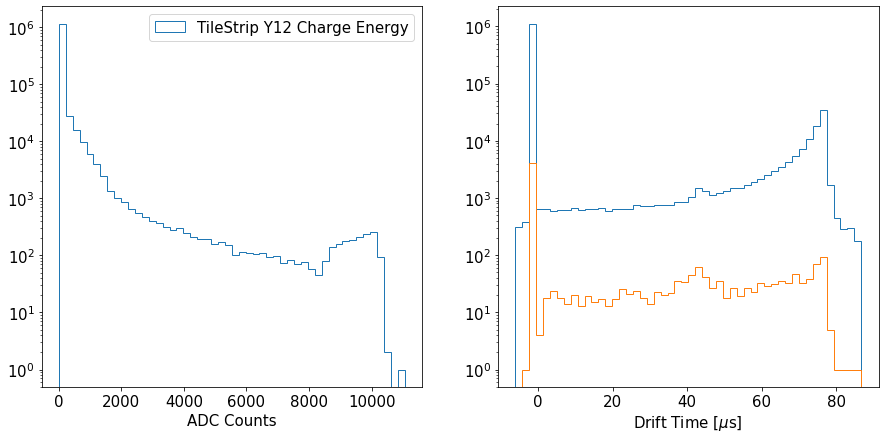

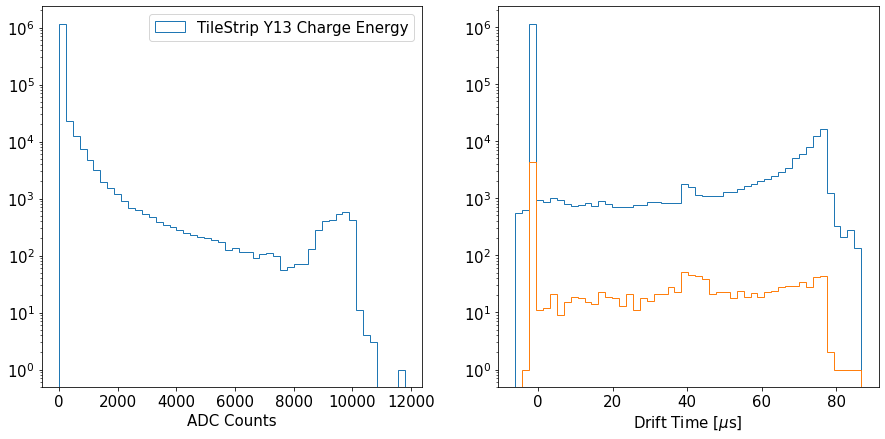

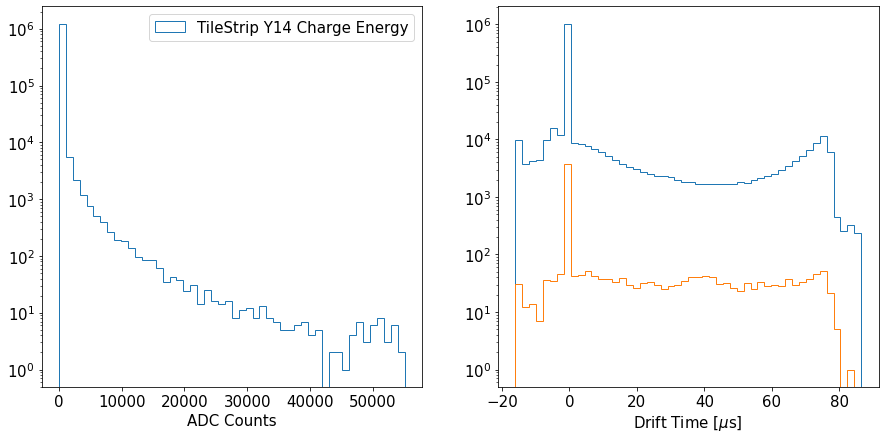

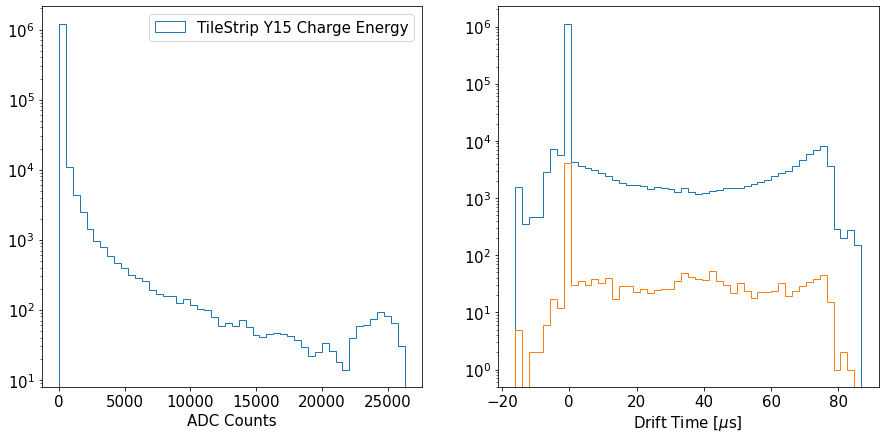

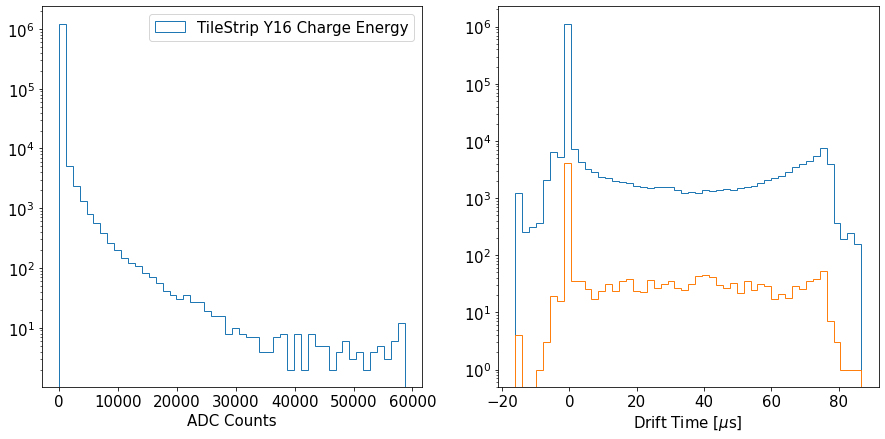

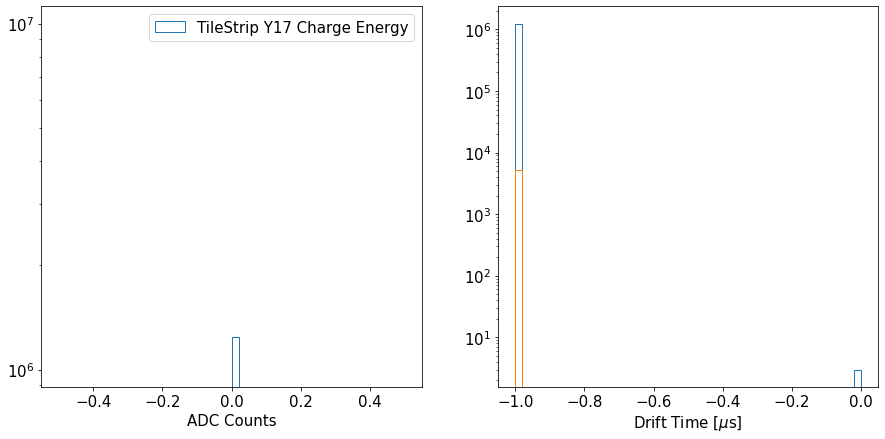

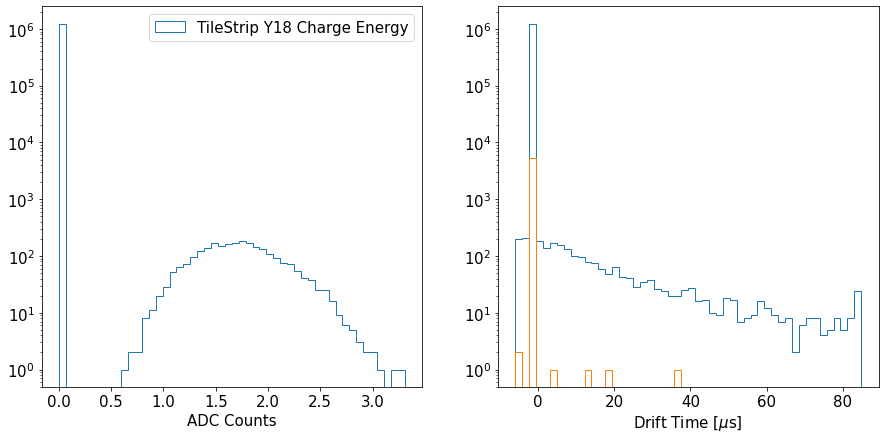

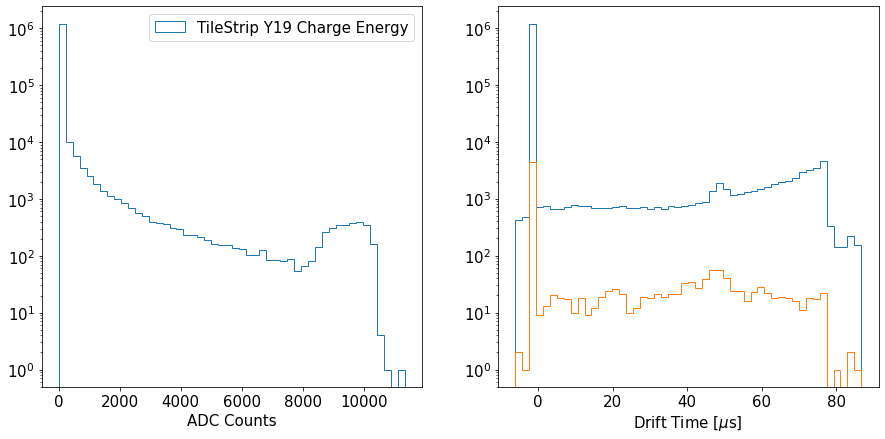

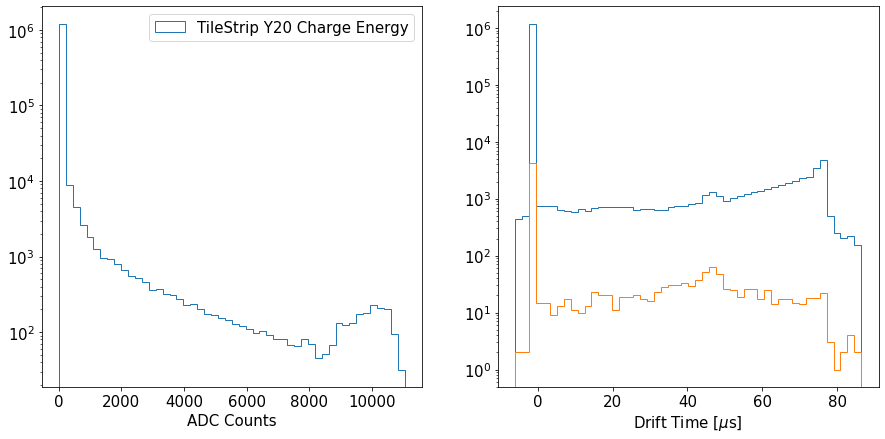

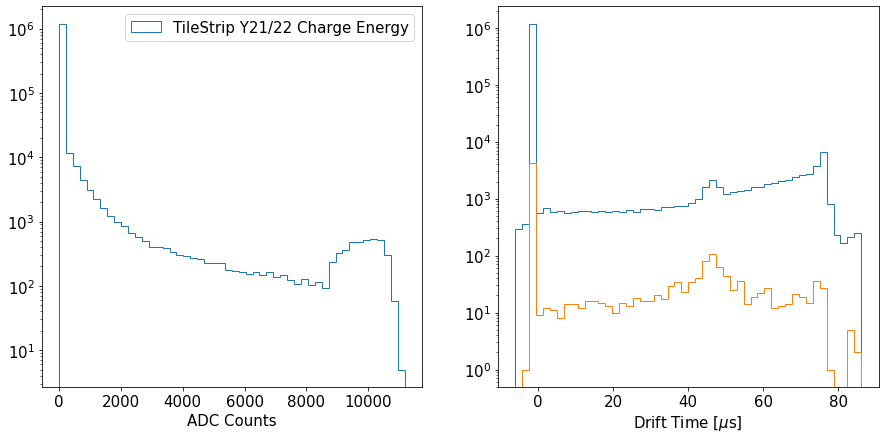

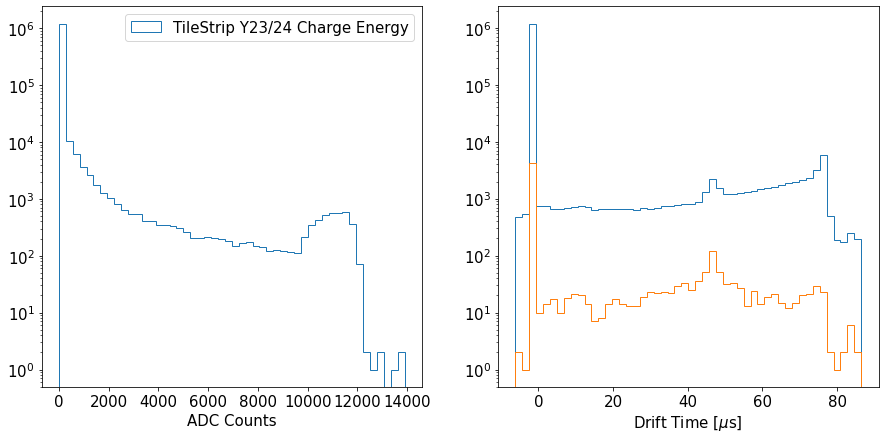

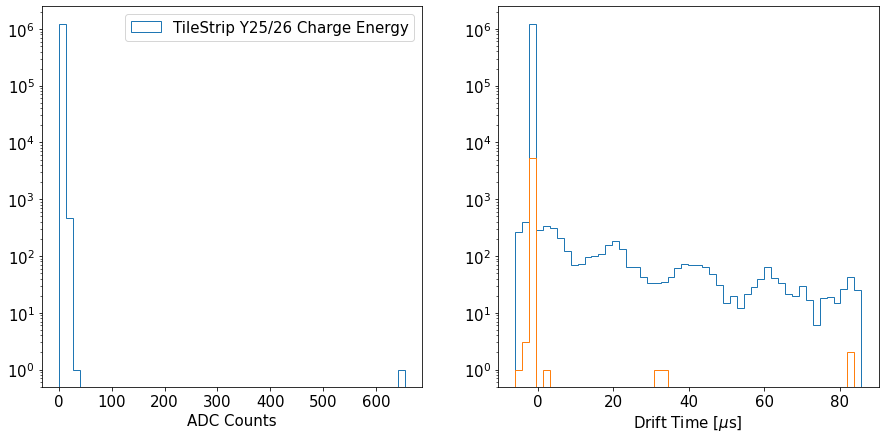

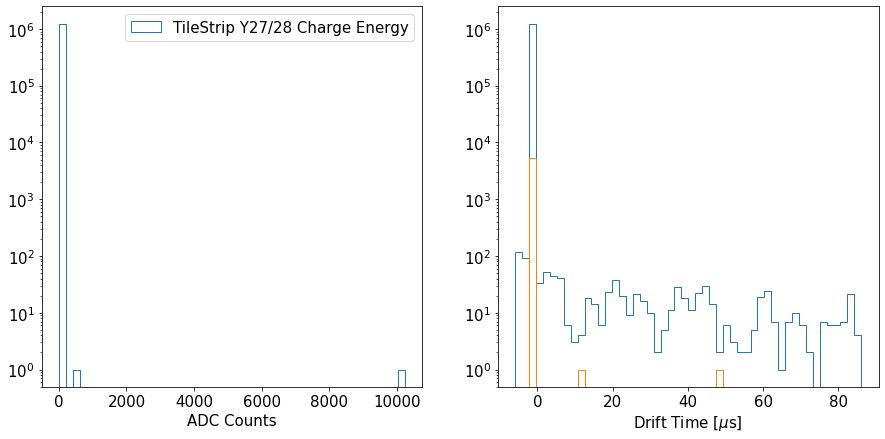

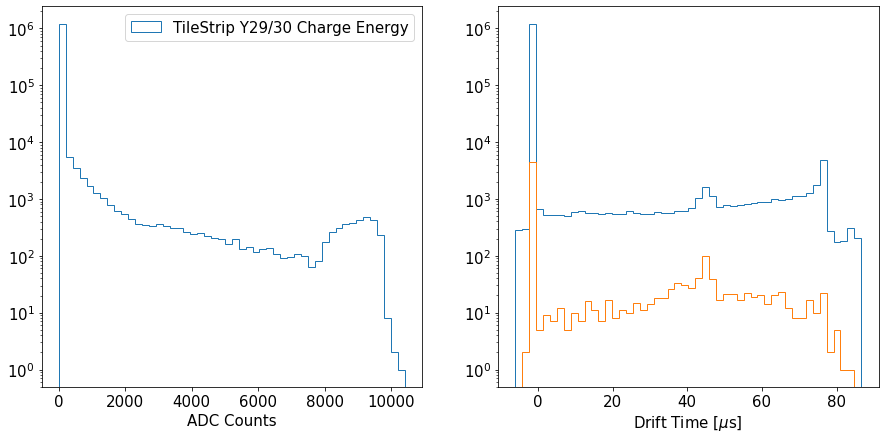

In [11]:
i = 0
bins = 50
analysis_config.GetCalibrationConstantsFromFile('/g/g90/jacopod/software/TMSAnalysis/config/Calibrations_Xe_Run11b.csv')
mask_time = np.logical_and(df['TileStrip X20 Drift Time']>35, df['TileStrip X20 Drift Time']<45)
for k in df.keys():
    if not (k.startswith('TileStrip') and k.endswith('Charge Energy')):
        continue
    ch_name = analysis_config.calibration_constants.index[i]
    i += 1
    fig,ax = plt.subplots(1,2,figsize=(15,7))
    ax[0].hist(df['{}'.format(k)],bins=bins,histtype='step',label=k,log=True)
    _, edges, _ = ax[1].hist(df['TileStrip {} Drift Time'.format(ch_name)],bins=bins,histtype='step',label=k,log=True)
    ax[0].set_xlabel('ADC Counts')
    ax[1].set_xlabel('Drift Time [$\mu$s]')
    #ax[1].hist(df['TileStrip {} Drift Time'.format(ch_name)][mask_time],bins=edges,histtype='step',label=k,log=True)
    ax[0].legend()
    plt.show()

Looking the spectrum of channels X1-12, X13, X19, X25/26, Y17, Y18, Y25/26, Y27/28 appear not to be recording, also the SC drift time distribution exhibit some bumpy structure in the following channels: X23/24, X25/26, X29/30, Y25/26, Y27/28

In [12]:
def merge_and_condition(array):
    mask = np.ones(np.shape(array[0]))
    for arr in array:
        mask = np.logical_and(mask,arr)
    return mask

Here I look for the alpha peak on the different channels by cutting for SC energy deposit with a quite tight (purity-corrected) energy range

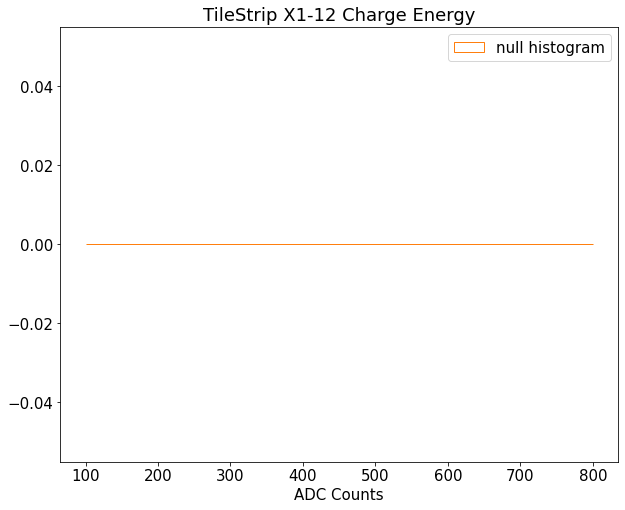

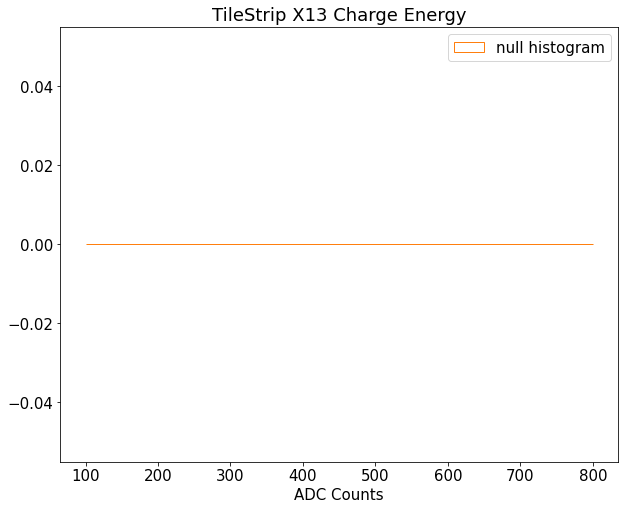

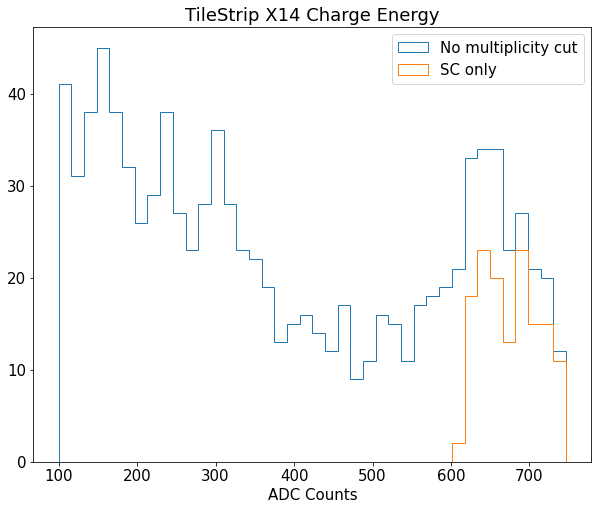

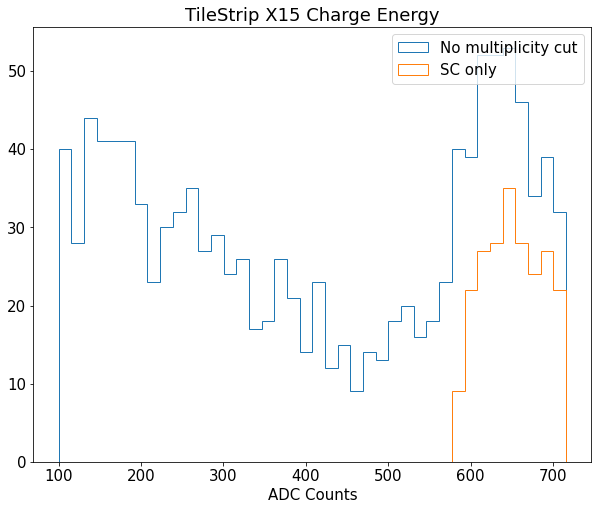

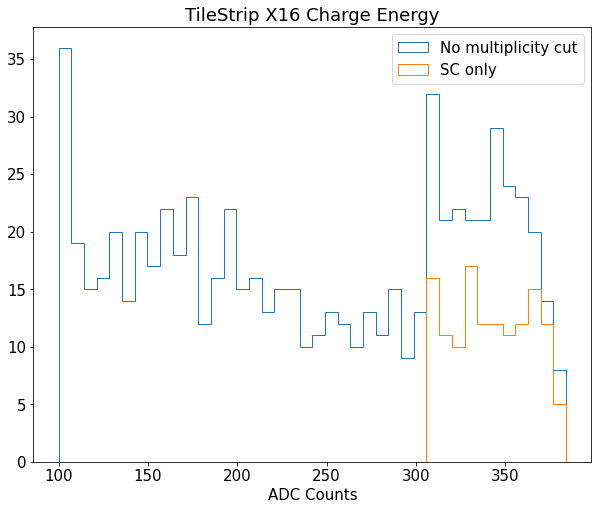

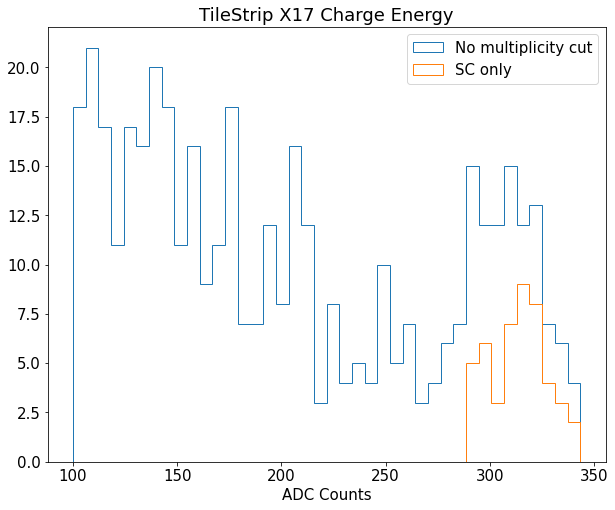

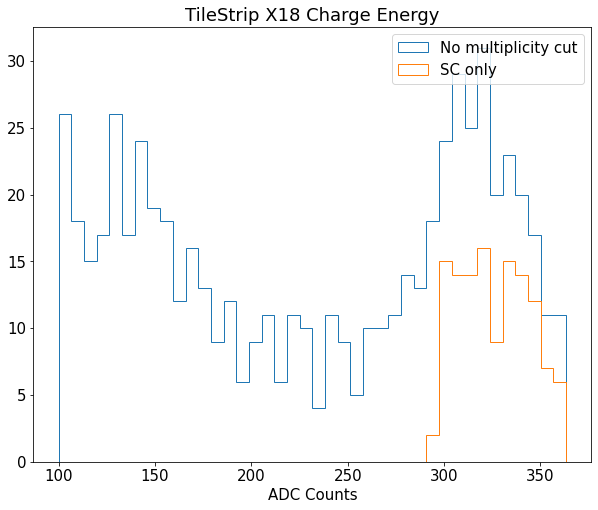

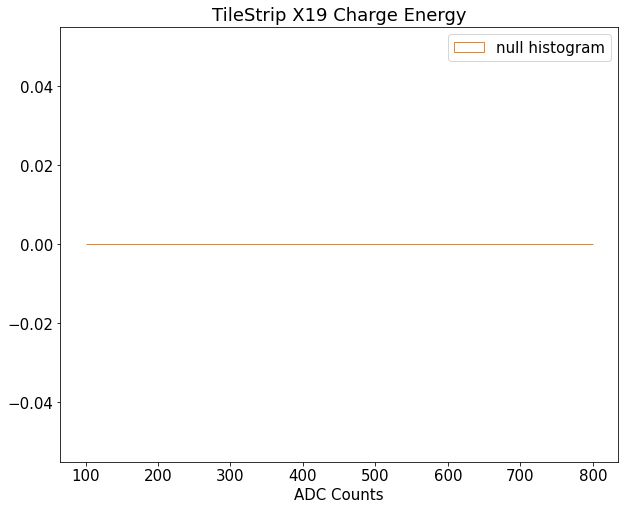

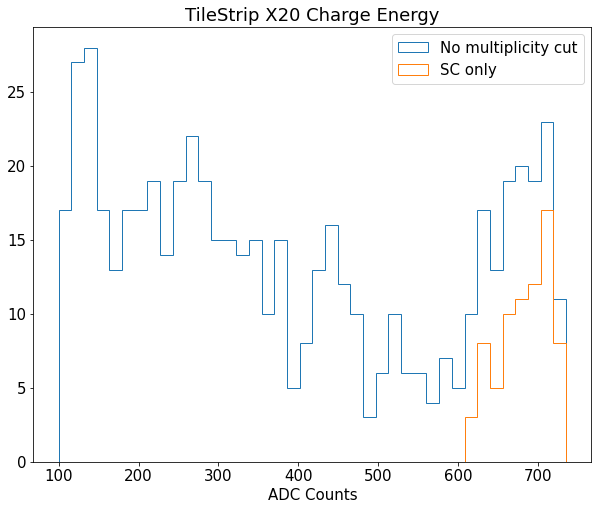

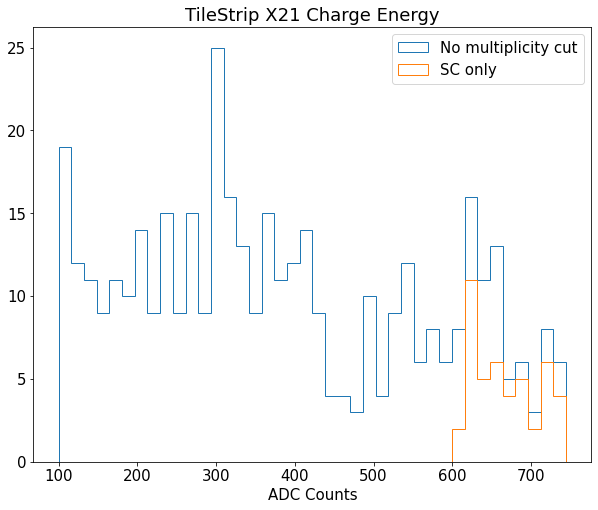

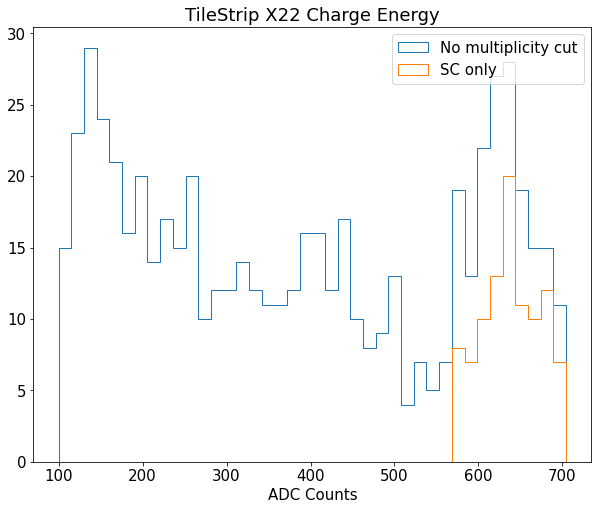

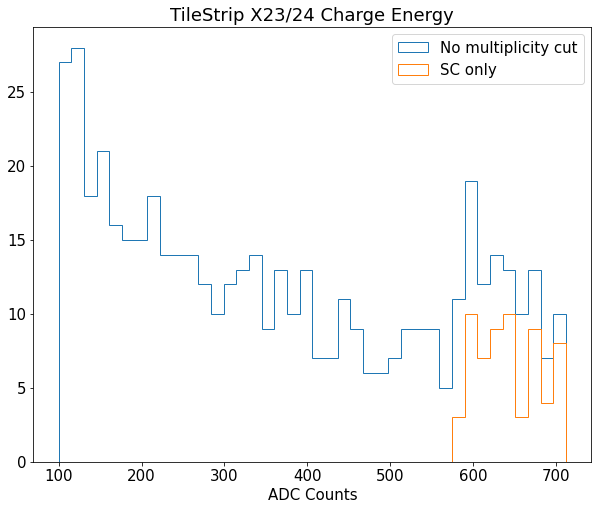

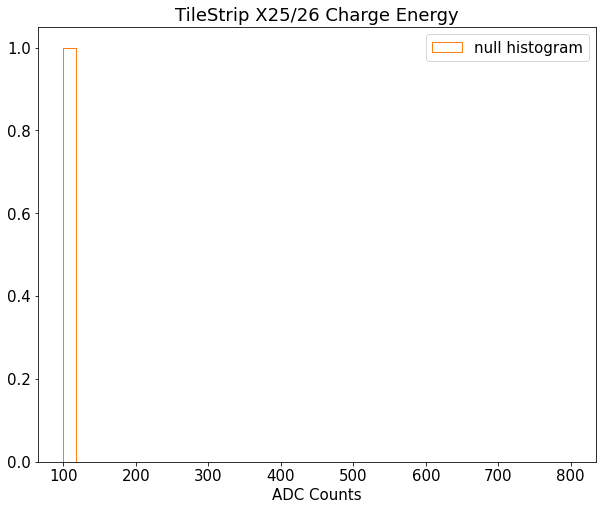

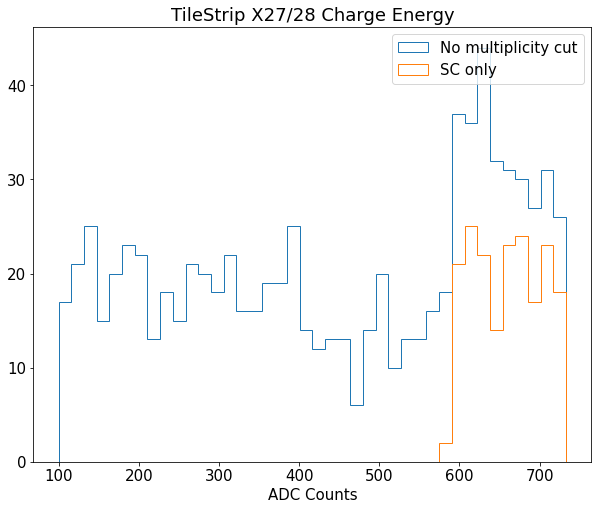

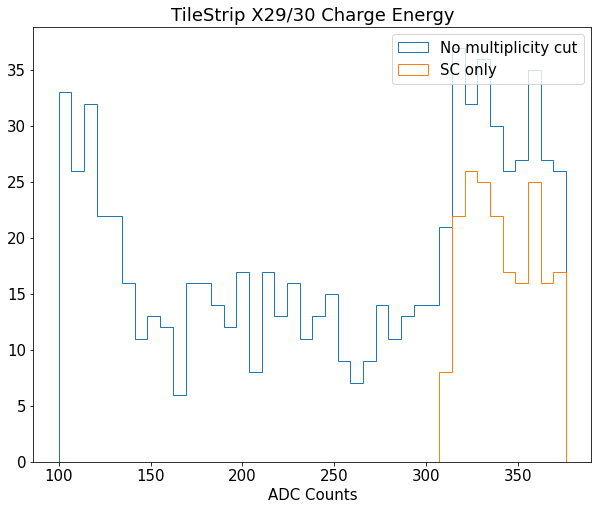

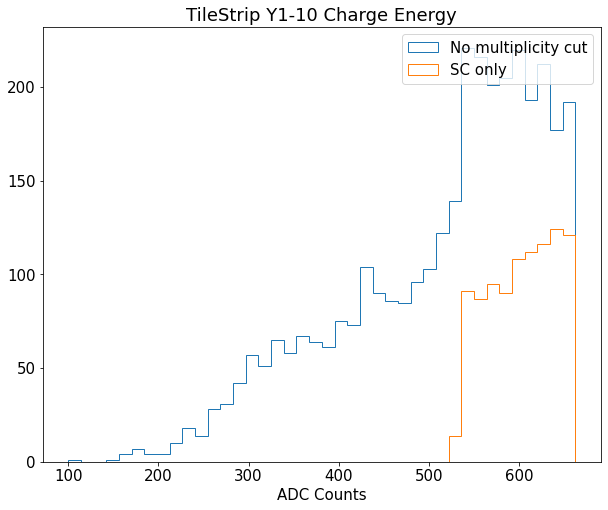

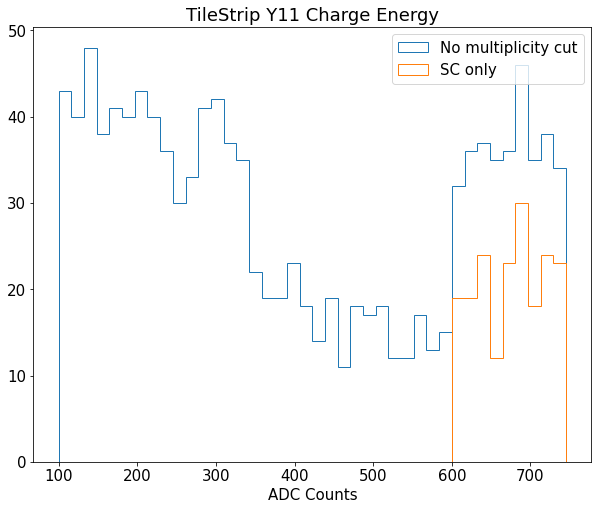

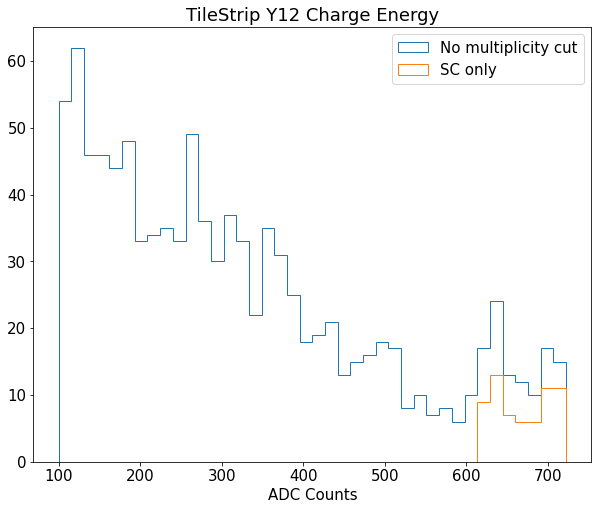

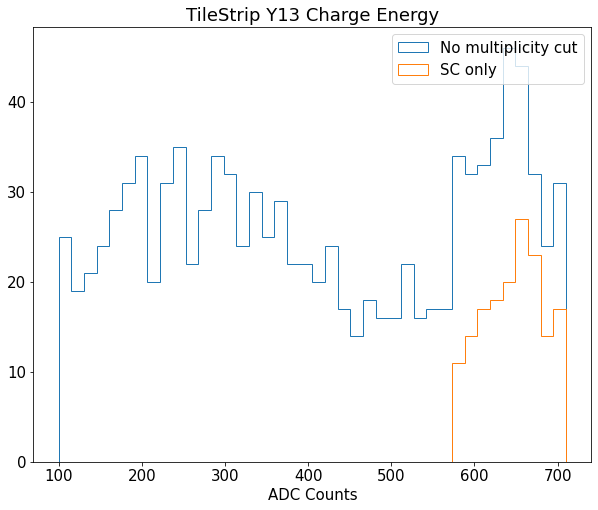

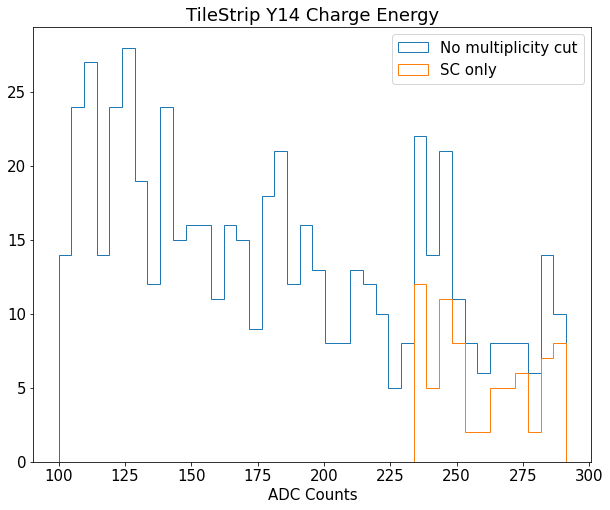

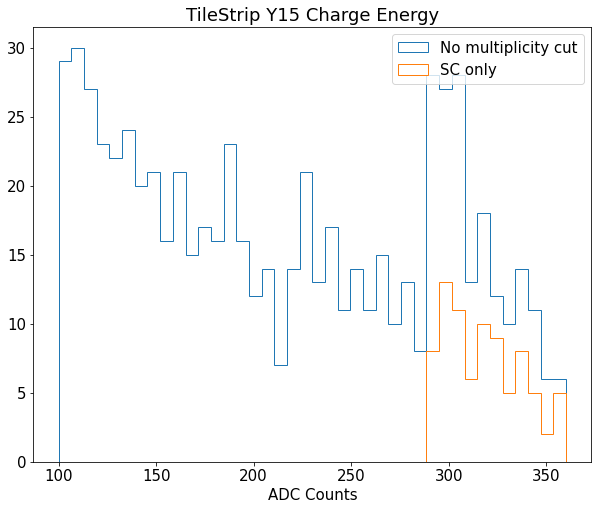

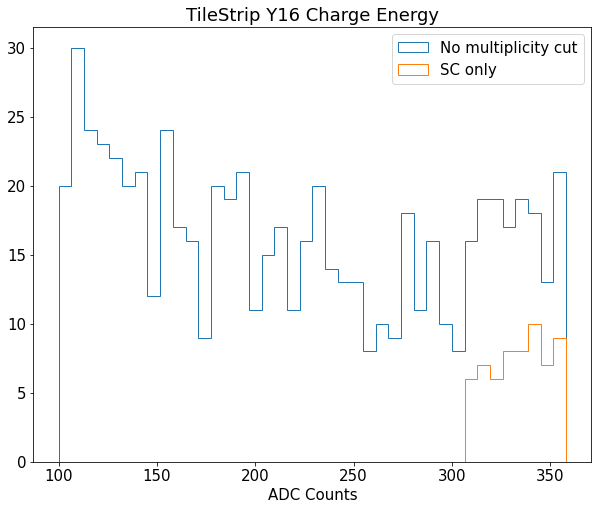

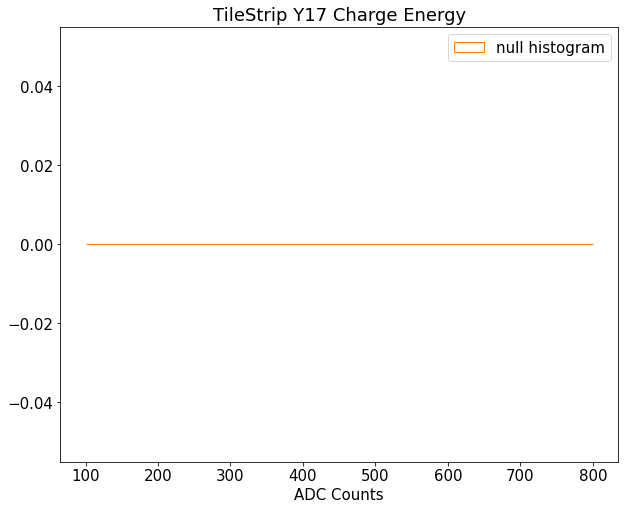

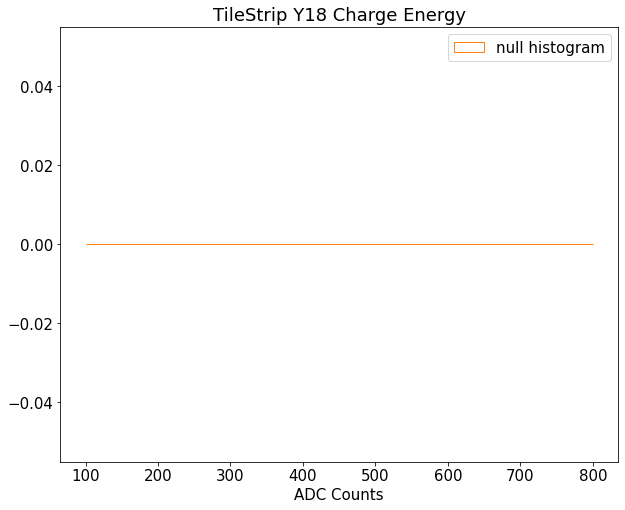

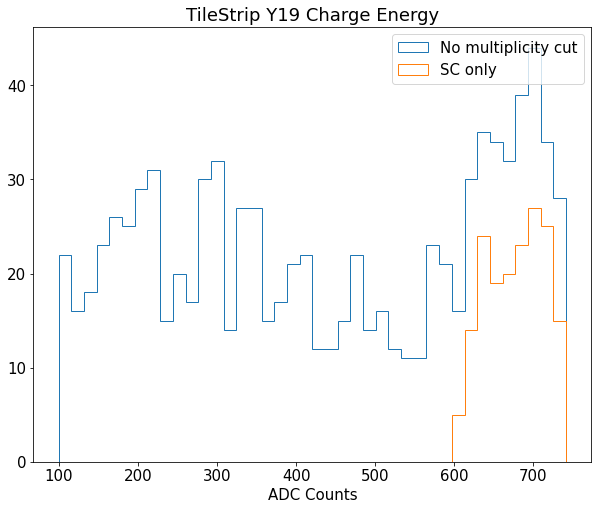

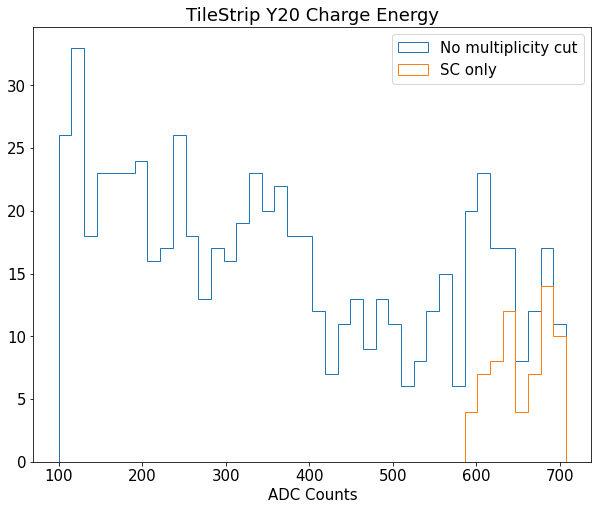

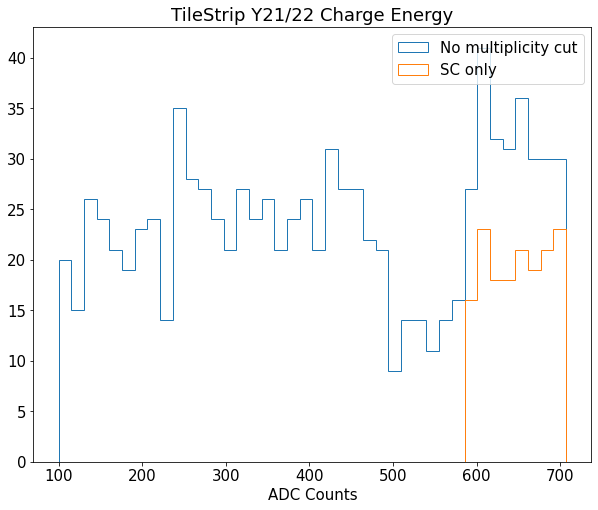

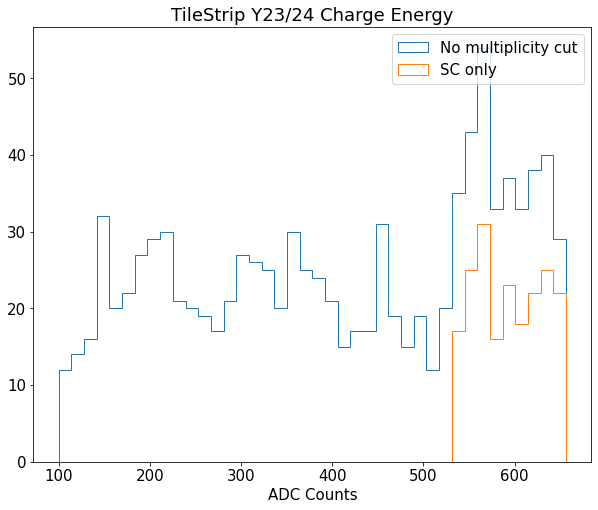

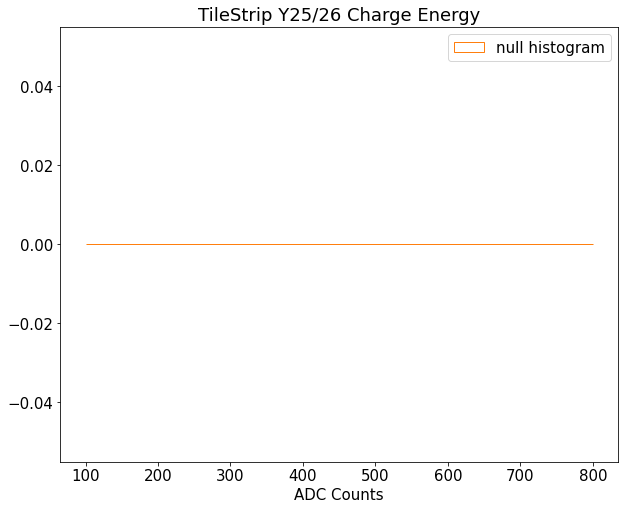

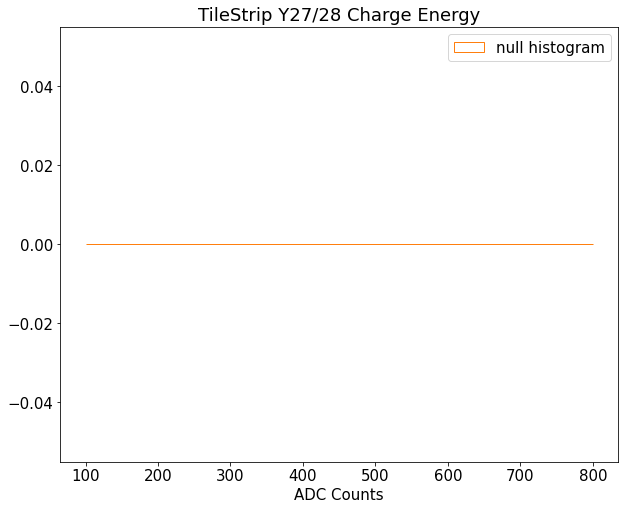

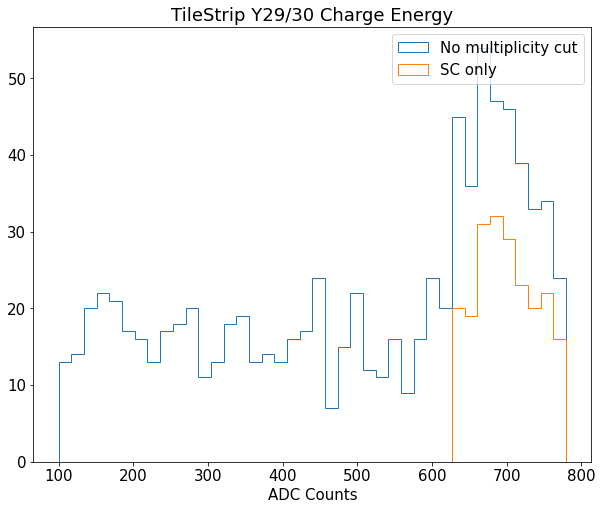

In [13]:
i = 0
bins = 40
mask_time   = np.logical_and(DriftTime>10, DriftTime<70)
mask_energy = np.logical_and(df['Purity-Corrected Charge Energy']>600,df['Purity-Corrected Charge Energy']<800)
mask = np.logical_and(mask_energy,mask_time)
cross_cal = pd.DataFrame(columns=['alpha','alpha_error','previous runs','channel'])
first = True
for k in df.keys():
    if not (k.startswith('TileStrip') and k.endswith('Charge Energy')):
        continue
    uncal_channel_energy = df['{}'.format(k)]/analysis_config.calibration_constants['Calibration'][i]
    purity_cor_uncal_channel_energy = uncal_channel_energy * np.exp(DriftTime/popt_e[1])
    
    mask_SS     = np.logical_and(df['{}'.format(k)]==df['TotalTileEnergy'],df['TotalTileEnergy']>0)
    mask_alpha  = np.logical_and(mask,mask_SS)
    try:
        plt.hist(purity_cor_uncal_channel_energy[mask],bins=bins,histtype='step',\
                 label='No multiplicity cut',range=(100,max(uncal_channel_energy[mask])))
        plt.hist(purity_cor_uncal_channel_energy[mask_alpha],bins=bins,histtype='step',\
                 label='SC only',range=(100,max(uncal_channel_energy[mask])))
        mean_energy = np.mean(purity_cor_uncal_channel_energy[mask_alpha])
        std_energy = np.std(purity_cor_uncal_channel_energy[mask_alpha])
        if first:
            first_energy = mean_energy
            first_error = std_energy
            first_cal = analysis_config.calibration_constants['Calibration'][i]
            first = False
        cross_cal = cross_cal.append({'alpha':mean_energy/first_energy,\
                                      'alpha_error':np.hypot(std_energy/mean_energy,first_error/first_energy)*\
                                      mean_energy/first_energy,\
                                      'previous runs':first_cal/analysis_config.calibration_constants['Calibration'][i],\
                                      'channel':analysis_config.calibration_constants.index[i]},\
                                     ignore_index=True)
    except ValueError:
        plt.hist(purity_cor_uncal_channel_energy[mask],bins=bins,histtype='step',label='null histogram',range=(100,800))
    plt.xlabel('ADC Counts')
    plt.title(k)
    plt.legend()
    plt.show()
    i += 1
cross_cal = cross_cal.set_index('channel')

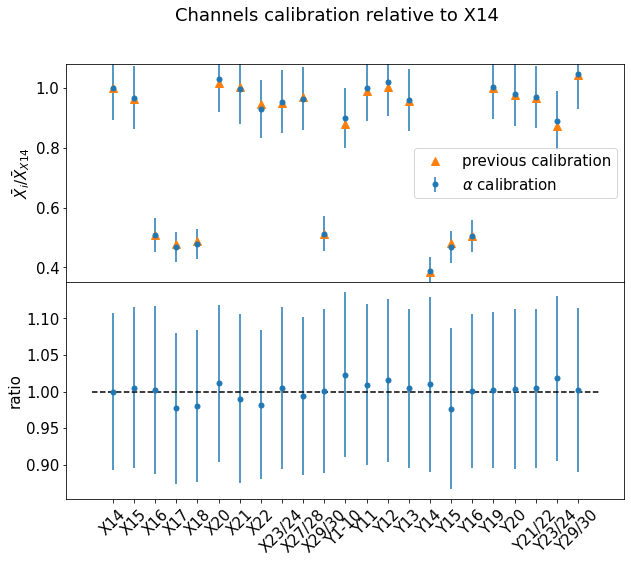

In [16]:
fig,ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(range(len(cross_cal)),cross_cal['alpha'],cross_cal['alpha_error'],fmt='.',markersize=10,\
               label=r'$\alpha$ calibration')
ax[0].plot(cross_cal['previous runs'],'.',markersize=8,label='previous calibration',marker='^')
ax[0].legend()
ax[0].set_ylabel(r'$\bar{X}_i/\bar{X}_{X14}$')
ax[1].errorbar(range(len(cross_cal)),cross_cal['alpha']/cross_cal['previous runs'],\
               cross_cal['alpha_error']/cross_cal['previous runs'],fmt='.',markersize=10)
ax[1].hlines(1.0, -1, len(cross_cal),linestyles='dashed')
ax[1].set_ylabel('ratio')
fig.suptitle('Channels calibration relative to X14')
plt.xticks(rotation=45)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

The top plot shows the ratio of the position of the alpha peak across the different channels with the position on X14. This is compared to the calibration coefficient (normalized to X14) used for previous runs from the $^{207}$Bi spectrum and they are completely consistent. Bottom plot is the ratio of the to dataset

## Is it possible to estimate the charge yield for alphas?

Once I verified the cross-calibration amongst channels is consistent, I can try in principle to estimate the charge yield for alphas. Supposing to know the gamma charge yield for the 570keV peak Y$_{\gamma}$ and its location on our spectrum Ch$_e$ it is possible to estimate the value of the alpha charge yield Y$_{\alpha}$ where the yields are measured in e$^-$/keV. 
In general the energy released in charge CE$_{\alpha}$ is given by: CE$_{\alpha}$ = Y$_{\alpha}$E$_i$E$_{\alpha}$\
where E$_i$ is the Xe ionization energy and E$_{\alpha}$ is the full energy of the alpha. Assuming a linear calibration m, the alpha peak will appear on the channel\
Ch$_\alpha$ = mCE$_{\alpha}$.\
Similarly CE$_{\gamma}$ is the product of Y$_{\gamma}$E$_i$E$_{\gamma}$ with E$_{\gamma}$ = 570keV, and it will appear on Ch$_\gamma$ = mCE$_{\gamma}$. Solving these two equation for m, I obtain:\
Y$_{\alpha}$ = Y$_{\gamma}$$\frac{\mathrm{Ch}_\alpha}{\mathrm{Ch}_\gamma}$$\frac{\mathrm{E}_{\gamma}}{\mathrm{E}_{\alpha}}$\
Taking from NEST Y$_{\gamma}$~43 e$^-$/keV for a 570keV $\gamma$ in 400V/cm E-field, I get Y$_{\alpha}$ = 1.71$\pm$0.11 e$^-$/keV, with E$_{\alpha}$ = 6.17MeV the alpha from $^{212}$Bi